# GNSS Line-of-Sight Velocities

In this notebook we will pull GNSS velocities from the University of Nevada-Reno's Nevada Geodetic Laboratory website. 
These data will be filtered to remove noisy stations and converted to line-of-sight velocities to compare to InSAR velocites. 

In [29]:
import h5py
import os
import rasterio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyproj import CRS, Transformer
from scipy.interpolate import RegularGridInterpolator

#### Files needed

In order to get line-of-sight velocities, we need geometry information for the station locations. 
For products processed using ASF's on-demand InSAR processing service, we will use the `*_lv_theta.tif` file to get the heading data for the sensor and the `geometryGeo.h5` file obtained from Mintpy after running the `smallbaselineApp.py` software to produce time-series from the ASF products. 

In [56]:
# define file names
working_directory = '.'  # put working directory here and make sure the files below are in it

lv_phi_file = working_directory + 'S1AA_20180110T001141_20180122T001141_VVP012_INT80_G_weF_204C_lv_phi.tif'
geometry_file = working_directory + 'geometryGeo.h5'

In [31]:
# Functions that we'll need

def mad(inp):
  return np.median(np.abs(inp - np.median(inp)))

def inc_hd_to_enu(incidence, heading, fmt='deg'):
    '''
    Convert incidence and heading to line-of-sight vectors from the ground to the top of
    the troposphere.

    Args:
        incidence: ndarray	       - incidence angle in deg from vertical
        heading: ndarray 	       - heading angle in deg clockwise from north
        lats/lons/heights: ndarray - WGS84 ellipsoidal target (ground pixel) locations

    Returns:
        LOS: ndarray  - (input_shape) x 3 array of unit look vectors in local ENU

    Algorithm referenced from http://earthdef.caltech.edu/boards/4/topics/327
    '''
    if np.any(incidence < 0):
        raise ValueError('inc_hd_to_enu: Incidence angle cannot be less than 0')

    if fmt=='deg':
        east = sind(incidence) * cosd(heading + 90)
        north = sind(incidence) * sind(heading + 90)
        up = cosd(incidence)
    else:
        east = np.sin(incidence) * np.cos(heading + 90)
        north = np.sin(incidence) * np.sin(heading + 90)
        up = np.cos(incidence)

    return east, north, up


def sind(x):
    """Return the sine of x when x is in degrees."""
    return np.sin(np.radians(x))
def cosd(x):
    """Return the cosine of x when x is in degrees."""
    return np.cos(np.radians(x))

To obtain GNSS velocities, we'll access a data URL from the Nevada Geodetic Laboratory

In [32]:
# Load GNSS data from UNR.
# Use GNSS data in North America reference frame
data_file = 'http://geodesy.unr.edu/velocities/midas.NA.txt'

In [33]:
# MIDAS velocity file format
column_names = [
    'ID',
    'MIDASversion',
    'first_epoch',
    'last_epoch',
    'duration_yrs',
    'N_epochs',
    'N_epochs_good',
    'N_vel_pairs',
    'Ve',
    'Vn',
    'Vu',
    'Se',
    'Sn',
    'Su',
    'E_initial_offset',
    'N_initial_offset',
    'U_initial_offset',
    'E_frac_outliers',
    'N_frac_outliers',
    'U_frac_outliers',
    'E_std_vel_pairs',
    'N_std_vel_pairs',
    'U_std_vel_pairs',
    'Nsteps',
    'lat',
    'lon',
    'hgt_m',
  ]

In [34]:
df = pd.read_csv(data_file, names=column_names, sep='\s+')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/97/ptdvc_cd42985hl35hz5yztr0000gp/T/ipykernel_26475/410591845.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(data_file, names=column_names, sep='\s+')


In [35]:
df.head()

,ID,MIDASversion,first_epoch,last_epoch,duration_yrs,N_epochs,N_epochs_good,N_vel_pairs,Ve,Vn,...,E_frac_outliers,N_frac_outliers,U_frac_outliers,E_std_vel_pairs,N_std_vel_pairs,U_std_vel_pairs,Nsteps,lat,lon,hgt_m
0,1LSU,MIDAS5,2003.3073,2024.2902,20.9829,7199,6228,8623,-0.000805,0.001503,...,0.042,0.044,0.057,0.003930,0.003065,0.008758,10,30.407425,-91.180262,-6.56646
1,1NSU,MIDAS5,2004.0411,2024.2902,20.2491,7274,7213,10928,-0.000807,0.002402,...,0.048,0.044,0.046,0.002117,0.002022,0.007338,4,31.750801,-93.097604,28.04620
2,1ULM,MIDAS5,2003.4497,2024.2902,20.8405,7375,7372,11250,-0.000549,0.001587,...,0.048,0.054,0.045,0.002181,0.001886,0.007473,4,32.529034,-92.075907,15.97255
3,299C,MIDAS5,2003.0308,2007.0856,4.0548,1408,1408,2159,0.006539,-0.001731,...,0.127,0.066,0.095,0.002195,0.001951,0.008442,0,64.028926,-142.075778,748.13639
4,3RIV,MIDAS5,1994.8172,2015.6715,20.8543,30,30,56,0.000401,-0.000723,...,0.000,0.143,0.125,0.000637,0.000428,0.001442,0,46.314763,-72.576085,-21.73074


In [36]:
# Define the region of interst (AOI)
lat_north = 37
lat_south = 34
lon_west = -95
lon_east = -91

In [37]:
mask = (df['lat'] < lat_north) & (df['lat'] > lat_south) & (df['lon'] < lon_east) & (df['lon'] > lon_west)
df_bbox = df[mask]
print(len(df_bbox))
df_bbox.head()

43


,ID,MIDASversion,first_epoch,last_epoch,duration_yrs,N_epochs,N_epochs_good,N_vel_pairs,Ve,Vn,...,E_frac_outliers,N_frac_outliers,U_frac_outliers,E_std_vel_pairs,N_std_vel_pairs,U_std_vel_pairs,Nsteps,lat,lon,hgt_m
346,ARAK,MIDAS5,2022.3381,2023.5455,1.2074,437,151,151,-0.001158,0.000147,...,0.026,0.073,0.053,0.002622,0.002020,0.006731,0,34.113421,-93.054561,37.17466
349,ARBA,MIDAS5,2021.2266,2023.5455,2.3189,844,844,961,-0.000166,0.001350,...,0.054,0.054,0.056,0.002064,0.002089,0.007764,0,35.771980,-91.649675,88.81093
350,ARBK,MIDAS5,2019.2279,2023.5455,4.3176,1577,1577,2425,-0.000620,0.001226,...,0.053,0.056,0.053,0.002120,0.001890,0.006955,0,34.886942,-91.196183,40.05931
352,ARBT,MIDAS5,2005.6044,2024.2902,18.6858,6450,6449,11684,-0.000353,0.001435,...,0.050,0.067,0.061,0.002074,0.002111,0.008537,1,35.709876,-91.628548,91.94339
353,ARBY,MIDAS5,2019.1786,2023.5455,4.3669,1595,1595,2460,-0.000324,0.001310,...,0.039,0.063,0.044,0.002228,0.001814,0.007329,0,36.355988,-93.580371,322.20360


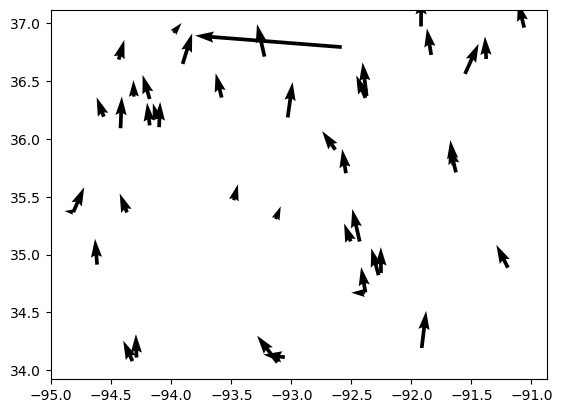

In [38]:
plt.quiver(df_bbox['lon'], df_bbox['lat'], df_bbox['Ve'], df_bbox['Vn'])

Steps:
1. Remove stations with errors OR with high uncertainty
2. Project GNSS velocities into the line-of-sight of our insar velocities
3. Put the Insar velocities into the GNSS frame of reference
4. Solve for a plane parameter of the difference

#### Remove stations with high errors

In [39]:
# Need to remove outlier velocities
mean_ve = df_bbox['Ve'].mean()
mean_vn = df_bbox['Vn'].mean()
std_ve = df_bbox['Ve'].std()
std_vn = df_bbox['Vn'].std()

print('Mean easting velocity: {:.2f} mm/yr'.format(mean_ve*1000))
print('Mean northing velocity: {:.2f} mm/yr'.format(mean_vn*1000))
print('Std easting velocity: {:.2f} mm/yr'.format(std_ve*1000))
print('Std northing velocity: {:.2f} mm/yr'.format(std_vn*1000))

Mean easting velocity: -0.36 mm/yr
Mean northing velocity: 1.21 mm/yr
Std easting velocity: 1.24 mm/yr
Std northing velocity: 0.46 mm/yr


In [40]:
print('Mean sigma_east: {:.2f} mm/yr'.format(df_bbox['Se'].mean()*1000))
print('Mean sigma_north: {:.2f} mm/yr'.format(df_bbox['Sn'].mean()*1000))

Mean sigma_east: 0.35 mm/yr
Mean sigma_north: 0.36 mm/yr


In [41]:
outlier_mask_1 = (df_bbox['Ve'] > mean_ve + 2 * std_ve) | (df_bbox['Ve'] < mean_ve - 2 * std_ve) | (df_bbox['Vn'] > mean_vn + 2 * std_vn) | (df_bbox['Vn'] < mean_vn - 2 * std_vn)
outlier_mask_2 = (df_bbox['Se']*1000 > 1) | (df_bbox['Sn']*1000 > 1)
outlier_mask_3 = df_bbox['duration_yrs'] < 5
outlier_mask_4 = df_bbox['N_epochs_good'] < 1000

outlier_mask_5 = df_bbox['Vn'] < 0 # this will only work for NA-reference velocities in this area

print(len(df_bbox))
print(np.sum(outlier_mask_1))
print(np.sum(outlier_mask_2))
print(np.sum(outlier_mask_3))
print(np.sum(outlier_mask_4))
print(np.sum(outlier_mask_5))

outlier_mask = outlier_mask_1 | outlier_mask_2 | outlier_mask_3 | outlier_mask_4 | outlier_mask_5

43
4
4
16
6
0


In [42]:
df_clean = df_bbox[~outlier_mask]

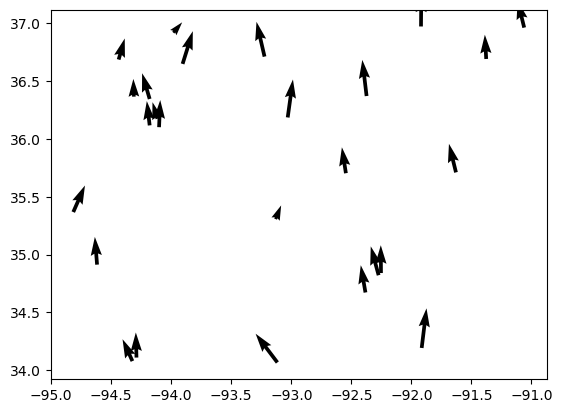

In [43]:
plt.quiver(df_clean['lon'], df_clean['lat'], df_clean['Ve'], df_clean['Vn'])

In [44]:
print('Mean easting velocity is {:.2f} mm/yr'.format(np.median(df_clean['Ve'] * 1000)))
print('Mean northing velocity is {:.2f} mm/yr'.format(np.median(df_clean['Vn'] * 1000)))

print('Mean sigma_east is {:.2f} mm/yr'.format(np.median(df_clean['Se'] * 1000)))
print('Mean sigma_north is {:.2f} mm/yr'.format(np.median(df_clean['Sn'] * 1000)))

print('Variablity in Veast is {:.2f} mm/yr'.format(mad(df_clean['Ve'] * 1000)))
print('Variablity in Vnorth is {:.2f} mm/yr'.format(mad(df_clean['Vn'] * 1000)))

print('Std of Veast is {:.2f} mm/yr'.format(df_clean['Ve'].std() * 1000))
print('Std of Veast is {:.2f} mm/yr'.format(df_clean['Vn'].std() * 1000))

Mean easting velocity is -0.09 mm/yr
Mean northing velocity is 1.36 mm/yr
Mean sigma_east is 0.19 mm/yr
Mean sigma_north is 0.18 mm/yr
Variablity in Veast is 0.25 mm/yr
Variablity in Vnorth is 0.14 mm/yr
Std of Veast is 0.37 mm/yr
Std of Veast is 0.35 mm/yr


In [45]:
df_clean.head()

,ID,MIDASversion,first_epoch,last_epoch,duration_yrs,N_epochs,N_epochs_good,N_vel_pairs,Ve,Vn,...,E_frac_outliers,N_frac_outliers,U_frac_outliers,E_std_vel_pairs,N_std_vel_pairs,U_std_vel_pairs,Nsteps,lat,lon,hgt_m
352,ARBT,MIDAS5,2005.6044,2024.2902,18.6858,6450,6449,11684,-0.000353,0.001435,...,0.050,0.067,0.061,0.002074,0.002111,0.008537,1,35.709876,-91.628548,91.94339
358,ARCT,MIDAS5,2016.7447,2023.5455,6.8008,2359,2359,4019,-0.000027,0.000891,...,0.129,0.052,0.150,0.002313,0.002442,0.008242,0,36.363941,-94.311402,391.90084
362,ARDQ,MIDAS5,2019.1841,2024.2902,5.1061,1846,1846,2978,-0.000496,0.001099,...,0.040,0.036,0.036,0.002170,0.001950,0.007363,0,34.080088,-94.323693,147.62246
365,ARFY,MIDAS5,2005.6044,2024.2902,18.6858,6583,6582,11745,-0.000143,0.001221,...,0.048,0.045,0.045,0.001938,0.001978,0.007538,1,36.115798,-94.180048,349.52929
366,ARGS,MIDAS5,2018.4723,2024.2902,5.8179,2115,2115,3508,-0.001093,0.001444,...,0.051,0.040,0.048,0.002160,0.002156,0.007528,0,34.068199,-93.116178,69.32106


#### Convert GNSS velocities to LOS

In [57]:
# read in geometry information
with rasterio.open(lv_phi_file, 'r') as f:
    hd_info = f.read(1)

with h5py.File(geometry_file, 'r') as f:
    inc = f['incidenceAngle'][()]

In [58]:
print(hd_info.shape)
print(inc.shape)

(2915, 3603)
(2915, 3603)


#### Interpolate GNSS points
The GNSS station locations are given in lat/lon but the InSAR may be in a UTM zone (default for ASF on-demand processing). We'll use the geocoded file containing look vector information to pull the CRS information and convert the GNSS lat/lon values to the InSAR locations.

In [59]:
with rasterio.open(lv_theta_file, 'r') as f:
    xy = f.xy
    trans = f.transform
    crs = f.crs
    bounds = f.bounds

crs_in = CRS.from_epsg(4326)
x = [trans[2] + trans[0]*k for k in range(hd_info.shape[1])]
y = [trans[5] + trans[4]*k for k in range(hd_info.shape[0])]

In [49]:
transformer = Transformer.from_crs(crs_in, crs, always_xy=True)
gnss_x, gnss_y = transformer.transform(df_clean['lon'], df_clean['lat'])
gnss_x.min(), gnss_x.max(), gnss_y.min(), gnss_y.max()

(334990.5721346386, 672667.2308931611, 3769723.856883381, 4092207.3544532363)

In [50]:
df_clean['x'] = gnss_x
df_clean.to_csv('filename.csv', index=False)

/var/folders/97/ptdvc_cd42985hl35hz5yztr0000gp/T/ipykernel_26475/3892903994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['x'] = gnss_x


Text(0, 0.5, 'Y')

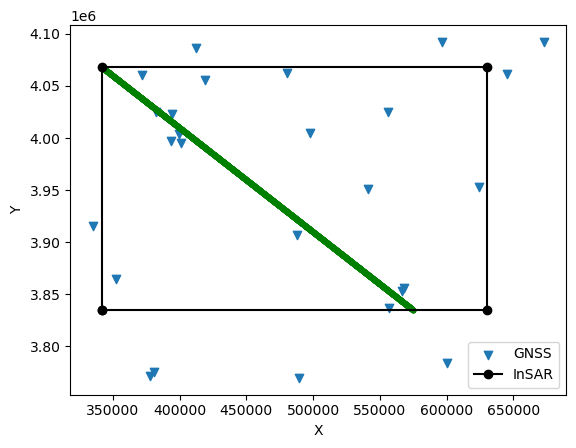

In [51]:
# make a plot of the extent of the InSAR and GNSS locations
plt.scatter(gnss_x, gnss_y, marker='v', label='GNSS')
plt.plot([bounds.left, bounds.left, bounds.right, bounds.right, bounds.left], [bounds.bottom, bounds.top, bounds.top, bounds.bottom, bounds.bottom], marker='o', c='k', label='InSAR')
plt.scatter(x[:len(y)],y,marker='.',c='g')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

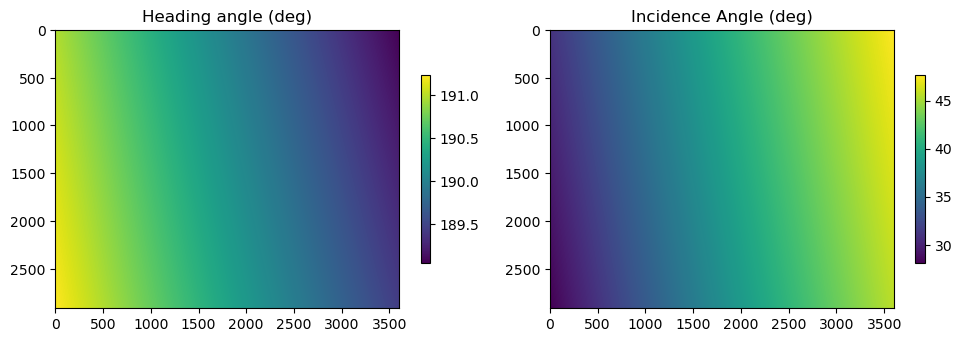

In [70]:
# Plot the heading angle and incidence angle information
fig, axs = plt.subplots(1, 2, figsize=(10,5))  # 1 row, 2 columns

# Plot data on each subplot
cax = axs[0].imshow(np.rad2deg(hd_info) + 360)
axs[0].set_title('Heading angle (deg)')
cbar = fig.colorbar(cax, ax=axs[0], shrink=0.4)

cax = axs[1].imshow(inc)
axs[1].set_title('Incidence Angle (deg)')
cbar = fig.colorbar(cax, ax=axs[1], shrink=0.4)

# Adjust layout
plt.tight_layout()


In [107]:
# Need to calculate the LOS vectors from incidence and heading rasters
inc_raster = inc

# heading angle is degrees ccw from east
if hd_info.mean() < 0:
    hd_deg = np.rad2deg(hd_info) + 360 # convert to positive degrees
else:
    hd_deg = np.rad2deg(hd_info)
az_raster = 90 - hd_info

# convert heading + incidence to ENU LOS unit vectors
LOSx, LOSy, LOSz = inc_hd_to_enu(inc_raster, az_raster, fmt='deg')

In [112]:
# Interpolate to get LOS vectors for the GNSS stations
Fx = RegularGridInterpolator((y,x), LOSx, bounds_error=False)
Fy = RegularGridInterpolator((y,x), LOSy, bounds_error=False)
Fz = RegularGridInterpolator((y,x), LOSz, bounds_error=False)

LOSx_g = Fx((gnss_y, gnss_x))
LOSy_g = Fy((gnss_y, gnss_x))
LOSz_g = Fz((gnss_y, gnss_x))

los_vel = df_clean['Ve'] * LOSx_g + df_clean['Vn'] * LOSy_g + df_clean['Vu'] * LOSz_g
df_clean['LOS_VEL'] = los_vel

/var/folders/97/ptdvc_cd42985hl35hz5yztr0000gp/T/ipykernel_26475/2052121441.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['LOS_VEL'] = los_vel


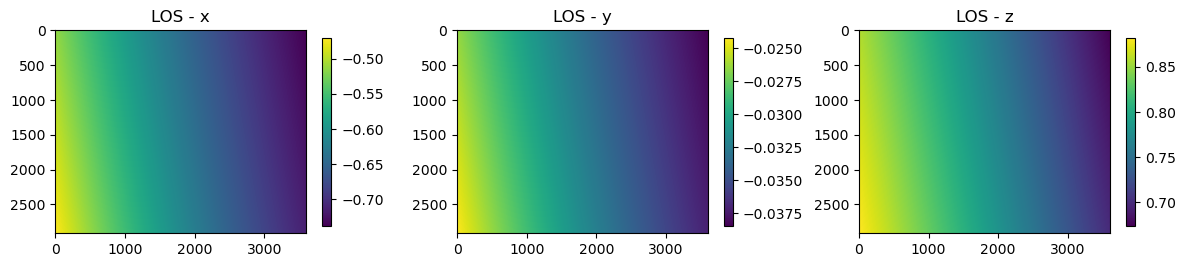

In [113]:
# Plot the LOS vector components
fig, axs = plt.subplots(1,3, figsize=(12,5))  # 1 row, 2 columns

# Plot data on each subplot
cax = axs[0].imshow(LOSx)
axs[0].set_title('LOS - x')
cbar = fig.colorbar(cax, ax=axs[0], shrink=0.4)

cax = axs[1].imshow(LOSy)
axs[1].set_title('LOS - y')
cbar = fig.colorbar(cax, ax=axs[1], shrink=0.4)

cax = axs[2].imshow(LOSz)
axs[2].set_title('LOS - z')
cbar = fig.colorbar(cax, ax=axs[2], shrink=0.4)

# Adjust layout
plt.tight_layout()

In [115]:
df_clean.head()

,ID,MIDASversion,first_epoch,last_epoch,duration_yrs,N_epochs,N_epochs_good,N_vel_pairs,Ve,Vn,...,U_frac_outliers,E_std_vel_pairs,N_std_vel_pairs,U_std_vel_pairs,Nsteps,lat,lon,hgt_m,x,LOS_VEL
352,ARBT,MIDAS5,2005.6044,2024.2902,18.6858,6450,6449,11684,-0.000353,0.001435,...,0.061,0.002074,0.002111,0.008537,1,35.709876,-91.628548,91.94339,624060.675984,-0.000283
358,ARCT,MIDAS5,2016.7447,2023.5455,6.8008,2359,2359,4019,-0.000027,0.000891,...,0.150,0.002313,0.002442,0.008242,0,36.363941,-94.311402,391.90084,382348.816383,0.000072
362,ARDQ,MIDAS5,2019.1841,2024.2902,5.1061,1846,1846,2978,-0.000496,0.001099,...,0.036,0.002170,0.001950,0.007363,0,34.080088,-94.323693,147.62246,377870.603606,NaN
365,ARFY,MIDAS5,2005.6044,2024.2902,18.6858,6583,6582,11745,-0.000143,0.001221,...,0.045,0.001938,0.001978,0.007538,1,36.115798,-94.180048,349.52929,393798.492378,-0.000871
366,ARGS,MIDAS5,2018.4723,2024.2902,5.8179,2115,2115,3508,-0.001093,0.001444,...,0.048,0.002160,0.002156,0.007528,0,34.068199,-93.116178,69.32106,489279.754088,NaN


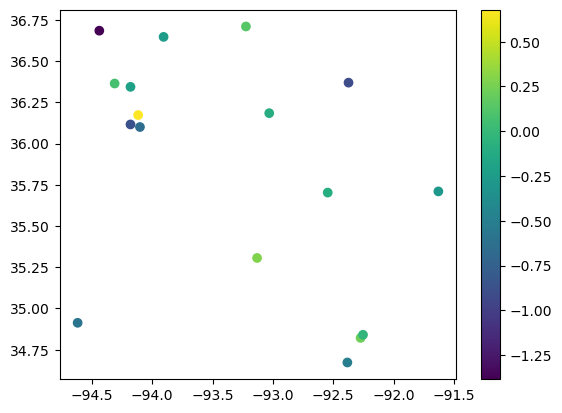

In [116]:
cax = plt.scatter(df_clean['lon'], df_clean['lat'], c=df_clean['LOS_VEL']*1000, marker='o')
plt.colorbar(cax)

In [117]:
print('Mean GNSS LOS velocity is {:.2f} mm/yr and st.dev. is {:.2f} mm/yr'.format(df_clean['LOS_VEL'].mean()*1000, df_clean['LOS_VEL'].std()*1000))

Mean GNSS LOS velocity is -0.27 mm/yr and st.dev. is 0.51 mm/yr
